In [16]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
from pytensor.tensor.subtensor import set_subtensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# Prediction of Time Series*

Adapted from [Unit 10: sunspots.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit10/sunspots.odc).

Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/sunspots.txt).

## Problem statement

Sunspot numbers observed each year from 1770 to 1869. 

BUGS Book Page 258.

In [17]:
y = np.loadtxt("../data/sunspots.txt")

In [18]:
y

array([100.8,  81.6,  66.5,  34.8,  30.6,   7. ,  19.8,  92.5, 154.4,
       125.9,  84.8,  68.1,  38.5,  22.8,  10.2,  24.1,  82.9, 132. ,
       130.9, 118.1,  89.9,  66.6,  60. ,  46.9,  41. ,  21.3,  16. ,
         6.4,   4.1,   6.8,  14.5,  34. ,  45. ,  43.1,  47.5,  42.2,
        28.1,  10.1,   8.1,   2.5,   0. ,   1.4,   5. ,  12.2,  13.9,
        35.4,  45.8,  41.1,  30.4,  23.9,  15.7,   6.6,   4. ,   1.8,
         8.5,  16.6,  36.3,  49.7,  62.5,  67. ,  71. ,  47.8,  27.5,
         8.5,  13.2,  56.9, 121.5, 138.3, 103.2,  85.8,  63.2,  36.8,
        24.2,  10.7,  15. ,  40.1,  61.5,  98.5, 124.3,  95.9,  66.5,
        64.5,  54.2,  39. ,  20.6,   6.7,   4.3,  22.8,  54.8,  93.8,
        95.7,  77.2,  59.1,  44. ,  47. ,  30.5,  16.3,   7.3,  37.3,
        73.9])

In [19]:
t = np.array(range(100))
yr = t + 1770

## Model 1

In [20]:
with pm.Model() as m1:

    eps_0 = pm.Normal("eps_0", 0, tau=0.0001)

    theta = pm.Normal("theta", 0, tau=0.0001)
    c = pm.Normal("c", 0, tau=0.0001)
    sigma = pm.Uniform("sigma", 0, 100)
    tau = 1 / (sigma**2)

    _m = c + theta * pt.roll(y, shift=-1)[:-1]
    m = set_subtensor(_m[0], y[0] - eps_0)

    _eps = y - m
    eps = set_subtensor(_eps[0], eps_0)

    pm.Normal("likelihood", mu=m, tau=tau, observed=y[:-1])

    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_0, theta, c, sigma]
/Users/aaron/mambaforge/envs/pymc/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/aaron/mambaforge/envs/pymc/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


In [21]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eps_0,-0.014,21.310,-40.006,39.924,0.209,0.201,10412.0,7932.0,1.0
theta,0.817,0.060,0.710,0.937,0.001,0.000,8147.0,7845.0,1.0
c,8.501,3.579,1.758,15.201,0.040,0.029,8081.0,7731.0,1.0
sigma,21.953,1.595,19.064,24.962,0.015,0.011,10940.0,8973.0,1.0


## Model 1 using built in AR(1)


In [22]:
with pm.Model() as m1_ar:

    rho = pm.Normal(
        "rho", 0, tau=0.0001, shape=2
    )  # shape of rho determines AR order
    sigma = pm.Uniform("sigma", 0, 100)

    # constant=True means rho[0] is the constant term (c from BUGS model)
    pm.AR("likelihood", rho=rho, sigma=sigma, constant=True, observed=y)

    trace = pm.sample(3000)

/Users/aaron/mambaforge/envs/pymc/lib/python3.11/site-packages/pymc/distributions/timeseries.py:621: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma]
/Users/aaron/mambaforge/envs/pymc/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/aaron/mambaforge/envs/pymc/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 2 seconds.


In [23]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho[0],8.721,3.572,2.070,15.458,0.049,0.036,5346.0,5707.0,1.0
rho[1],0.808,0.060,0.694,0.920,0.001,0.001,5248.0,5349.0,1.0
sigma,21.814,1.601,18.806,24.781,0.019,0.013,7213.0,7306.0,1.0


## Prediction Step

We have our model, now we forecast the next 10 years:


In [24]:
# Forecast 10 years ahead
n_fcast = 10
y_fcast = np.zeros(n_fcast + 2)
y_fcast[:2] = y[-2:]

# Extract the mean of the posterior for rho (AR(1) model)
rho_mean = trace.posterior["rho"].mean(axis=(0, 1)).values

# Forecast based on the last observed point for AR(1)
for i in range(1, n_fcast + 2):
    y_fcast[i] = rho_mean[0] + rho_mean[1] * y_fcast[i - 1]

y_forecast = y_fcast[2:]

# Extend the year array for the forecast period
t_fcast = np.arange(yr[-1] + 1, yr[-1] + 1 + n_fcast)

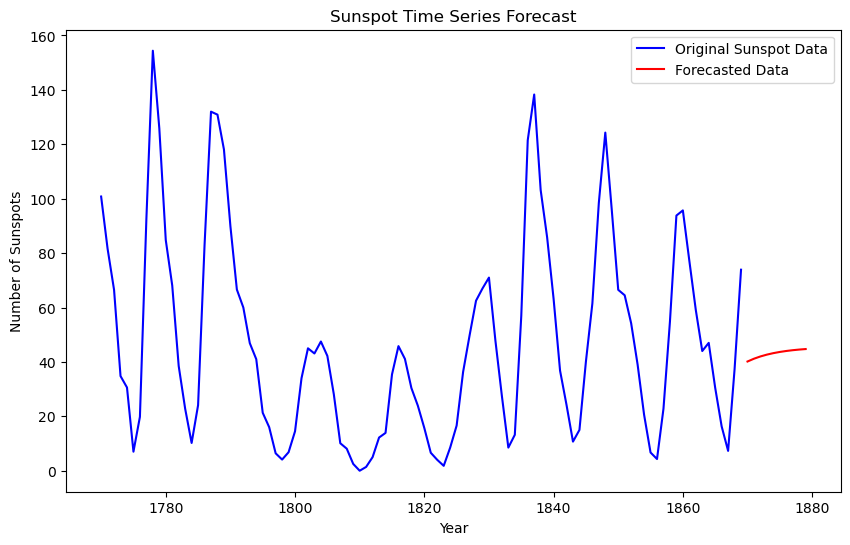

In [25]:
# Plot the original time series with the forecast

plt.figure(figsize=(10, 6))
plt.plot(yr, y, label="Original Sunspot Data", color="blue")
plt.plot(t_fcast, y_forecast, label="Forecasted Data", color="red")
plt.xlabel("Year")
plt.ylabel("Number of Sunspots")
plt.legend()
plt.title("Sunspot Time Series Forecast")
plt.show()

## Model 2: ARMA(2,1)

Because the forecast only utilizes the last value to forecast, we will enhance the model by adding another AR term, as well as a Moving Average (MA) term.

We use pymc_experimental.BayesianSARIMA to achieve this. As of 9/16/2024, this functionality is still in the experimentation repo, however it allows for a greatly reduced codebase. Coding an ARMA(2,1) method from scratch is lengthy. See [here](https://www.pymc.io/projects/experimental/en/latest/_modules/pymc_experimental/statespace/models/SARIMAX.html#BayesianSARIMA.__init__) for documentation.

In [26]:
import pymc_experimental.statespace as pmss
import pymc as pm
import pymc.sampling_jax as pjax

# As BayesianSARIMA does not include an intercept term,
# we can force it by centering the data

y_mean = y.mean()
y_centered = y - y_mean
y2 = y_centered.reshape(-1, 1)

# ARMA(2,1) model
ss_mod = pmss.BayesianSARIMA(order=(2, 0, 1), verbose=True)

with pm.Model(coords=ss_mod.coords) as arma_model:

    # Priors
    state_sigmas = pm.Uniform(
        "sigma_state", 0, 100, dims=ss_mod.param_dims["sigma_state"]
    )
    ar_params = pm.Normal(
        "ar_params", 0, tau=0.0001, dims=ss_mod.param_dims["ar_params"]
    )
    ma_params = pm.Normal(
        "ma_params", 0, tau=0.0001, dims=ss_mod.param_dims["ma_params"]
    )

    # Build Statespace Model
    ss_mod.build_statespace_graph(y2, mode="JAX")

    # Inference Data
    trace = pm.sample(nuts_sampler="numpyro", target_accept=0.9)

The following parameters should be assigned priors inside a PyMC model block: 
	ar_params -- shape: (2,), constraints: None, dims: ('ar_lag',)
	ma_params -- shape: (1,), constraints: None, dims: ('ma_lag',)
	sigma_state -- shape: None, constraints: Positive, dims: ()
/Users/aaron/mambaforge/envs/pymc/lib/python3.11/site-packages/pymc_experimental/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [27]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar_params[1],1.217,0.118,0.987,1.430,0.003,0.002,1364.0,1179.0,1.0
ar_params[2],-0.551,0.112,-0.761,-0.341,0.003,0.002,1373.0,1128.0,1.0
ma_params[1],0.378,0.139,0.108,0.627,0.003,0.003,1557.0,1720.0,1.0
sigma_state,15.056,1.090,13.067,17.173,0.024,0.017,2182.0,1677.0,1.0


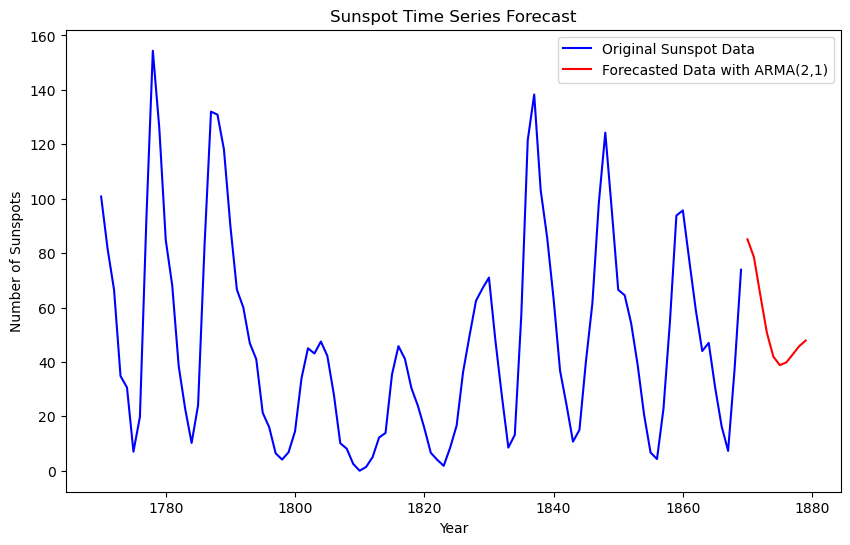

In [28]:
# Means of AR, MA, and Sigma
ar_mean = trace.posterior["ar_params"].mean(dim=("chain", "draw")).values
ma_mean = trace.posterior["ma_params"].mean(dim=("chain", "draw")).values
sigma_mean = trace.posterior["sigma_state"].mean(dim=("chain", "draw")).values

# Residuals
epsilon_fcast = np.zeros(n_fcast + 2)
epsilon_fcast[:2] = 0

# Forecast 10 periods ahead
n_fcast = 10
y_fcast = np.zeros(n_fcast + 2)
y_fcast[:2] = y_centered[-2:]

for i in range(2, n_fcast + 2):

    # Future error term
    epsilon_t = 0
    y_fcast[i] = (
        ar_mean[0] * y_fcast[i - 1]
        + ar_mean[1] * y_fcast[i - 2]
        + ma_mean[0] * epsilon_fcast[i - 1]
        + epsilon_t
    )

    # Update the error term
    epsilon_fcast[i] = epsilon_t

y_forecast = y_fcast[2:] + y_mean  # Add the mean back
t_fcast = np.arange(yr[-1] + 1, yr[-1] + 1 + n_fcast)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(yr, y, label="Original Sunspot Data", color="blue")
plt.plot(
    t_fcast, y_forecast, label="Forecasted Data with ARMA(2,1)", color="red"
)
plt.xlabel("Year")
plt.ylabel("Number of Sunspots")
plt.legend()
plt.title("Sunspot Time Series Forecast")
plt.show()

Written by Taylor Bosier and Aaron Reding.

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Sep 18 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pytensor: 2.25.4

matplotlib       : 3.8.3
pytensor         : 2.25.4
pandas           : 2.2.1
arviz            : 0.17.1
pymc_experimental: 0.1.2
pymc             : 5.16.2
numpy            : 1.26.4

